In [205]:
import pickle
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import Image
plt.rcParams['figure.figsize'] = [15, 15]

import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader


#from utils import aboutCudaDevices
from dataset_mod import MyDataset, default_loader
from solver import reconstruction_loss, kl_divergence, to_var
from model import conv_VAE_32, conv_VAE_64

from visuals import traverse_z, plotsave_tests


%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
image_paths = "/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/train/orig/"
target_paths = "/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/train/inverse/"

In [207]:
torch.cuda.is_available()

False

In [210]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [211]:
dset = MyDataset
train_data = dset(image_paths,target_paths, image_size= 32)
train_data.__len__()


9800

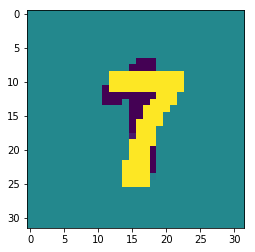

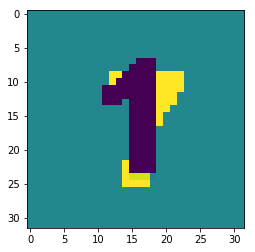

In [212]:
sample = train_data.__getitem__(40)
plt.imshow(sample["x"][0,:,:])
plt.figure()
plt.imshow(sample["y"][0,:,:])
plt.show()

In [213]:
batch_size= 256
num_workers = 4
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=False,
                          drop_last=False)

In [214]:
vae = conv_VAE_32(z_dim=22)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [221]:
# if you have more than one GPU parallelize the model
if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    vae = nn.DataParallel(vae)

# copy the model to each device
vae.to(device)

conv_VAE_32(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace)
    (6): View()
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU(inplace)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU(inplace)
    (11): Linear(in_features=256, out_features=44, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=22, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): View()
    (7): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU(inplace)
    (9): ConvT

In [218]:
next(vae.parameters()).is_cuda

False

In [222]:
epochs = 1
beta = 1
size_data = train_data.__len__()

%timeit
for epoch in range(epochs):
    #scheduler.step()
    pbar = tqdm(total=int(size_data/batch_size))
    for idx, sample in enumerate(train_loader):
        pbar.update(1)
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        x_recon, mu, logvar = vae(x)
        recon_loss = reconstruction_loss(y, x_recon, 'gaussian')
        total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
        
        beta_vae_loss = recon_loss + beta*total_kld
        print(beta_vae_loss.data/batch_size)

        optimizer.zero_grad()
        beta_vae_loss.backward()
        optimizer.step()
    
    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, beta_vae_loss.data[0]/batch_size))
    
            #recon_x, _, _ = vae(fixed_x)
            #save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')















  0%|          | 0/38 [00:00<?, ?it/s]













  3%|▎         | 1/38 [00:20<12:25, 20.14s/it]

torch.Size([256, 1, 32, 32])
tensor([0.1720])
















  5%|▌         | 2/38 [00:22<08:58, 14.95s/it]

torch.Size([256, 1, 32, 32])
tensor([0.1699])
















  8%|▊         | 3/38 [00:25<06:31, 11.19s/it]

torch.Size([256, 1, 32, 32])
tensor([0.1722])
















 11%|█         | 4/38 [00:27<04:50,  8.54s/it]

torch.Size([256, 1, 32, 32])
tensor([0.1709])


KeyboardInterrupt: 

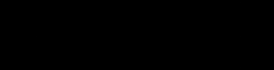

In [181]:
sample = torch.randn(16, 22)
test_recon = vae._decode(sample)
# recon_x, _, _ = vae(fixed_x)
#test_recon= test_recon.detach().numpy()

torchvision.utils.save_image(test_recon.view(test_recon.size(0), 1, 32, 32).data.cpu(), 'sample_image.png')
Image('sample_image.png')

In [182]:
vis = traverse_z(vae)

0 0
22 1


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [184]:
test_image_paths = "/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/test/orig/"
test_target_paths = "/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/test/inverse/"
pdf_path = "/Users/riccardoconci/Desktop/2_dig_fixed_random_bw/digts/testing_recon.pdf"

plotsave_tests(vae, MyDataset,test_image_paths,test_target_paths,pdf_path,20 )


In [32]:
import imageio

z_dim = 20
num_frames=20
indexs = np.arange(0, num_frames*z_dim, z_dim)

import os
import numpy as np

for i in indexs:
    images = []
    for e in range(num_frames):
        #print(i+e)
        filename = 'traversals/z{}/img{}.png'.format(int(i/num_frames),e)
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        torchvision.utils.save_image(F.sigmoid(reconst[i+e,0,:,:].cpu()) , filename)
        
        images.append(imageio.imread(filename))
    filename_2 = 'traversals_gifs/traversing_z_{}.gif'.format(int(i/z_dim),int(i/z_dim))
    directory_2 = os.path.dirname(filename_2)
    if not os.path.exists(directory_2):
            os.makedirs(directory_2)
    imageio.mimsave('traversals_gifs/traversing_z_{}.gif'.format(int(i/z_dim),int(i/z_dim)), images)


NameError: name 'reconst' is not defined